In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
from transformers import CLIPProcessor, CLIPModel,BertTokenizer, BertModel
from PIL import Image
from tqdm import tqdm
import random
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [2]:

business_df = pd.read_json('yelp_academic_dataset_business.json', lines=True,nrows=10000)
user_df = pd.read_json('yelp_academic_dataset_user.json', lines=True,nrows=10000)
review_df = pd.read_json('yelp_academic_dataset_review.json', lines=True,nrows=10000)
photo_df = pd.read_json('photos.json', lines=True,nrows=10000)
business_ids = set(business_df['business_id'])
user_ids = set(user_df['user_id'])
review_df = review_df[review_df['business_id'].isin(business_ids) & review_df['user_id'].isin(user_ids)]

data = pd.merge(review_df, user_df, on='user_id', suffixes=('_review', '_user'))
data = pd.merge(data, business_df, on='business_id', suffixes=('', '_business'))

user_encoder = LabelEncoder()
data['user_index'] = user_encoder.fit_transform(data['user_id'])
business_encoder = LabelEncoder()
data['business_index'] = business_encoder.fit_transform(data['business_id'])
num_users = data['user_index'].nunique()
num_businesses = data['business_index'].nunique()
print(data.columns.tolist())

['review_id', 'user_id', 'business_id', 'stars', 'useful_review', 'funny_review', 'cool_review', 'text', 'date', 'name', 'review_count', 'yelping_since', 'useful_user', 'funny_user', 'cool_user', 'elite', 'friends', 'fans', 'average_stars', 'compliment_hot', 'compliment_more', 'compliment_profile', 'compliment_cute', 'compliment_list', 'compliment_note', 'compliment_plain', 'compliment_cool', 'compliment_funny', 'compliment_writer', 'compliment_photos', 'name_business', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars_business', 'review_count_business', 'is_open', 'attributes', 'categories', 'hours', 'user_index', 'business_index']


In [8]:
user_features_list = ['review_count', 'useful_user', 'funny_user', 'cool_user', 'fans', 'average_stars']

scaler = StandardScaler()
user_features = scaler.fit_transform(data[user_features_list])
def process_categories(x):
    if isinstance(x, str):
        categories = x.split(', ')
    elif isinstance(x, list):
        categories = x
    else:
        categories = []
    categories = set(categories)
    categories.discard('') 
    return list(categories)

business_df['categories'] = business_df['categories'].fillna('').apply(process_categories)

# 使用 MultiLabelBinarizer 进行二值化
mlb = MultiLabelBinarizer()
categories_encoded = mlb.fit_transform(business_df['categories'])
categories_df = pd.DataFrame(categories_encoded, columns=mlb.classes_)

# 重置索引并合并数据框
business_df = business_df.reset_index(drop=True)
categories_df = categories_df.reset_index(drop=True)
business_df = pd.concat([business_df, categories_df], axis=1)

# 创建需要的商家特征列表
business_columns_needed = ['business_id', 'latitude', 'longitude'] + list(mlb.classes_)

# 检查是否存在重复的列名
if len(business_columns_needed) != len(set(business_columns_needed)):
    print("存在重复的商家特征列名，请检查类别处理。")

# 提取所需的商家特征
business_df_reduced = business_df[business_columns_needed]
data = pd.merge(data, business_df_reduced, on='business_id', how='left')
business_id_to_index = dict(zip(business_encoder.classes_, business_encoder.transform(business_encoder.classes_)))

business_index_to_categories = {}
for idx, row in business_df.iterrows():
    business_id = row['business_id']
    categories = row['categories'] 
    business_index = business_id_to_index.get(business_id)
    if business_index is not None:
        business_index_to_categories[business_index] = categories

category_to_business_indices = {}
for business_index, categories in business_index_to_categories.items():
    for category in categories:
        if category not in category_to_business_indices:
            category_to_business_indices[category] = set()
        category_to_business_indices[category].add(business_index)
business_features_list = ['latitude', 'longitude'] + list(mlb.classes_)
common_business_ids = set(data['business_id']).intersection(set(business_df_reduced['business_id']))
data = pd.merge(data, business_df_reduced, on='business_id', how='inner')
missing_columns = [col for col in business_features_list if col not in data.columns]
missing_columns = [col for col in business_features_list if col not in data.columns]
for col in missing_columns:
    data[col] = 0
business_features = scaler.fit_transform(data[business_features_list])
missing_columns = [col for col in business_features_list if col not in data.columns]
print(f"Missing columns: {missing_columns}")
business_features = scaler.fit_transform(data[business_features_list])
missing_columns = [col for col in business_features_list if col not in data.columns]

business_features = scaler.fit_transform(data[business_features_list])
use_model = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')
tokenizer = BertTokenizer.from_pretrained('./bert-base-uncased')
bert_model = BertModel.from_pretrained('./bert-base-uncased')
bert_model.to(device)
bert_model.eval()

def get_bert_embedding(text):
    if not isinstance(text, str) or text.strip() == '':
        return np.zeros(768)
    try:
        inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = bert_model(**inputs)
        embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()[0]
        return embedding
    except Exception as e:
        print(f"Error processing text: {text}")
        print(e)
        return np.zeros(768)
data = data.dropna(subset=['text'])
tqdm.pandas()
data['text_embedding'] = data['text'].progress_apply(get_bert_embedding)
photo_df = photo_df[photo_df['business_id'].isin(business_df['business_id'])]
business_photos = photo_df.groupby('business_id')['photo_id'].apply(list).reset_index()
business_df = pd.merge(business_df, business_photos, on='business_id', how='left')
clip_model = CLIPModel.from_pretrained("./clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("./clip-vit-base-patch32")
clip_model.to(device)
clip_model.eval()

def get_image_embedding(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        inputs = clip_processor(images=image, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = clip_model.get_image_features(**inputs)
        embedding = outputs.cpu().numpy()[0]
        return embedding
    except Exception as e:
        return np.zeros(512)

def get_business_image_embedding(photo_ids):
    embeddings = []
    if not isinstance(photo_ids, list):
        return np.zeros(512)
    for photo_id in photo_ids:
        image_path = os.path.join('photos', f'{photo_id}.jpg') 
        embedding = get_image_embedding(image_path)
        if np.count_nonzero(embedding) > 0:
            embeddings.append(embedding)
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(512)

tqdm.pandas()
business_df['image_embedding'] = business_df['photo_id'].progress_apply(get_business_image_embedding)

business_image_embeddings = business_df[['business_id', 'image_embedding']]
data = pd.merge(data, business_image_embeddings, on='business_id', how='left')
user_features = np.array(user_features)
business_features = np.array(business_features)
text_embeddings = np.stack(data['text_embedding'].values)
image_embeddings = np.stack(data['image_embedding'].values)

user_indices = data['user_index'].values
business_indices = data['business_index'].values

user_feature_dict = {}
for idx, user_id in enumerate(data['user_index'].unique()):
    user_feature_dict[user_id] = user_features[data['user_index'] == user_id][0]

business_feature_dict = {}
for idx, business_id in enumerate(data['business_index'].unique()):
    business_feature_dict[business_id] = business_features[data['business_index'] == business_id][0]

business_text_embedding_dict = {}
for idx, business_id in enumerate(data['business_index'].unique()):
    business_text_embedding_dict[business_id] = text_embeddings[data['business_index'] == business_id][0]

business_image_embedding_dict = {}
for idx, business_id in enumerate(data['business_index'].unique()):
    business_image_embedding_dict[business_id] = image_embeddings[data['business_index'] == business_id][0]


d:\python37\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Passing 'suffixes' which cause duplicate columns {'latitude_x', 'longitude_x'} in the result is deprecated and will raise a MergeError in a future version.
d:\python37\lib\site-packages\ipykernel_launcher.py:56: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Patio Coverings_x', 'Masonry/Concrete_x', 'Aquariums_x', 'Strip Clubs_x', 'Employment Law_x', 'Pet Breeders_x', 'Active Life_x', 'Jails & Prisons_x', 'Childbirth Education_x', 'Jewelry Repair_x', 'Kickboxing_x', 'Dim Sum_x', 'Sandwiches_x', 'Pool Cleaners_x', 'Delis_x', 'Building Supplies_x', 'Personal Injury Law_x', 'Adult Entertainment_x', 'Metal Fabricators_x', 'Tiki Bars_x', 'Public Markets_x', 'Customized Merchandise_x', 'Race Tracks_x', 'Sports Bars_x', 'Wigs_x', 'Trailer Dealers_x', 'Fruits & Veggies_x', 'Scavenger Hunts_x', 'Pubs_x', 'Window Washing_x', 'Emergency Pet Hospital_x', 'Vocational & Technical School_x', 'Graphic Design_x', 

d:\python37\lib\site-packages\ipykernel_launcher.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Missing columns: []


Some weights of the model checkpoint at ./bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|█████████████| 10000/10000 [00:17<00:00, 581.92it/s]


In [9]:
class YelpDataset(Dataset):
    def __init__(self, data, num_businesses, business_index_to_categories, category_to_business_indices, num_negatives=10):
        self.data = data
        self.num_businesses = num_businesses
        self.num_negatives = num_negatives
        self.business_index_to_categories = business_index_to_categories
        self.category_to_business_indices = category_to_business_indices
        
        self.user_business_set = set(zip(data['user_index'], data['business_index']))
        self.user_positive_businesses = data.groupby('user_index')['business_index'].apply(set).to_dict()
        self.all_businesses = set(range(num_businesses))
        self.user_indices = data['user_index'].values
        self.business_indices = data['business_index'].values
        self.user_locations = data.groupby('user_index')[['latitude', 'longitude']].mean().to_dict('index')
        self.business_locations = data.groupby('business_index')[['latitude', 'longitude']].mean().to_dict('index')
    
    def __len__(self):
        return len(self.user_indices)
    
    def __getitem__(self, idx):
        user = self.user_indices[idx]
        pos_business = self.business_indices[idx]

        candidate_neg_businesses = self.all_businesses - self.user_positive_businesses[user]

        neg_businesses = self.sample_hard_negatives(user, candidate_neg_businesses, self.num_negatives)

        return user, pos_business, neg_businesses

    def sample_hard_negatives(self, user, candidate_neg_businesses, num_negatives):
        user_location = self.user_locations.get(user)
        candidate_businesses = list(candidate_neg_businesses)
        distances = []
        for business in candidate_businesses:
            business_location = self.business_locations.get(business)
            if business_location and user_location:
                distance = haversine(user_location['longitude'], user_location['latitude'],
                                     business_location['longitude'], business_location['latitude'])
                distances.append((business, distance))
            else:
                distances.append((business, float('inf')))
        distances.sort(key=lambda x: x[1])
        hard_negatives = [b for b, d in distances[:num_negatives]]
        return hard_negatives

def haversine(lon1, lat1, lon2, lat2):
    import math
    R = 6371
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)
    a = math.sin(delta_phi / 2.0) ** 2 + \
        math.cos(phi1) * math.cos(phi2) * \
        math.sin(delta_lambda / 2.0) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    meters = R * c * 1000
    return meters

In [10]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

train_dataset = YelpDataset(train_data, num_businesses, business_index_to_categories, category_to_business_indices, num_negatives=5)
val_dataset = YelpDataset(val_data, num_businesses, business_index_to_categories, category_to_business_indices, num_negatives=5)
def custom_collate(batch):
    user_indices = torch.tensor([item[0] for item in batch], dtype=torch.long)
    pos_business_indices = torch.tensor([item[1] for item in batch], dtype=torch.long)
    neg_business_indices = [item[2] for item in batch] 
    neg_business_indices = torch.tensor(neg_business_indices, dtype=torch.long)
    return user_indices, pos_business_indices, neg_business_indices
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, collate_fn=custom_collate)


In [11]:
class TwoTowerModel(nn.Module):
    def __init__(self, user_feature_dim, business_feature_dim, embedding_dim):
        super(TwoTowerModel, self).__init__()
        self.user_tower = nn.Sequential(
            nn.Linear(user_feature_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_dim)
        )
        self.business_tower = nn.Sequential(
            nn.Linear(business_feature_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_dim)
        )

    def forward(self, user_features, business_features):
        user_vector = self.user_tower(user_features)
        business_vector = self.business_tower(business_features)
        user_vector = F.normalize(user_vector, p=2, dim=1)
        business_vector = F.normalize(business_vector, p=2, dim=1)
        return user_vector, business_vector

In [12]:
def contrastive_loss(user_vector, pos_business_vector, neg_business_vectors, temperature=0.07):
    batch_size = user_vector.size(0)
    user_vector = user_vector.unsqueeze(1) 
    pos_business_vector = pos_business_vector.unsqueeze(1)
    all_business_vectors = torch.cat([pos_business_vector, neg_business_vectors], dim=1) 
    sim_matrix = torch.bmm(user_vector, all_business_vectors.permute(0, 2, 1)) 
    sim_matrix = sim_matrix.squeeze(1) / temperature  
    
    labels = torch.zeros(batch_size, dtype=torch.long).to(device)
    loss = F.cross_entropy(sim_matrix, labels)
    return loss
def get_hard_negatives(user_idx, pos_business_idx, num_negatives):
    user_positive_businesses = user_positive_businesses_dict[user_idx]
    candidate_neg_businesses = all_businesses - user_positive_businesses
    hard_negatives = random.sample(candidate_neg_businesses, num_negatives)
    return hard_negatives
def get_user_features(user_indices):
    user_features_batch = []
    for user_idx in user_indices.cpu().numpy():
        user_features_batch.append(user_feature_dict[user_idx])
    user_features_batch = torch.tensor(user_features_batch, dtype=torch.float).to(device)
    return user_features_batch
def get_business_features(business_indices):
    business_features_batch = []
    for business_idx in business_indices.cpu().numpy():
        features = np.concatenate([
            business_feature_dict[business_idx],
            business_text_embedding_dict[business_idx],
            business_image_embedding_dict[business_idx]
        ])
        business_features_batch.append(features)
    business_features_batch = torch.tensor(business_features_batch, dtype=torch.float).to(device)
    return business_features_batch

In [13]:
def train_model(model, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0
    for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
        user_indices, pos_business_indices, neg_business_indices = batch
        user_indices = user_indices.to(device)
        pos_business_indices = pos_business_indices.to(device)
        neg_business_indices = neg_business_indices.to(device)

        user_features_batch = get_user_features(user_indices) 

        pos_business_features_batch = get_business_features(pos_business_indices) 

        # 获取负样本商家特征
        batch_size, num_negatives = neg_business_indices.shape
        neg_business_indices_flat = neg_business_indices.view(-1)
        neg_business_features_batch = get_business_features(neg_business_indices_flat)  
        neg_business_features_batch = neg_business_features_batch.view(batch_size, num_negatives, -1)  

        optimizer.zero_grad()
        user_vector = model.user_tower(user_features_batch) 
        pos_business_vector = model.business_tower(pos_business_features_batch)  
        neg_business_vectors = []
        for i in range(num_negatives):
            neg_business_vector = model.business_tower(neg_business_features_batch[:, i, :]) 
            neg_business_vectors.append(neg_business_vector.unsqueeze(1))  
        neg_business_vectors = torch.cat(neg_business_vectors, dim=1) 

        loss = contrastive_loss(user_vector, pos_business_vector, neg_business_vectors)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Training Loss: {avg_loss:.4f}")

In [14]:
def evaluate_model(model, val_loader, epoch, k=10):
    model.eval()
    ndcgs = []
    maps = []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Evaluating Epoch {epoch+1}"):
            user_indices, pos_business_indices, _ = batch
            user_features_batch = get_user_features(user_indices)
            pos_business_indices = pos_business_indices.cpu().numpy()

            user_vector = model.user_tower(user_features_batch)
            user_vector = F.normalize(user_vector, p=2, dim=1)
            
            business_vectors = []
            for i in range(num_businesses):
                features = get_business_features(torch.tensor([i]))
                business_vector = model.business_tower(features)
                business_vector = F.normalize(business_vector, p=2, dim=1)
                business_vectors.append(business_vector)
            business_vectors = torch.cat(business_vectors, dim=0)

            scores = torch.matmul(user_vector, business_vectors.T)
            _, indices = torch.topk(scores, k, dim=1)

            for i in range(len(user_indices)):
                pos_business = pos_business_indices[i]
                recommended_businesses = indices[i].cpu().numpy()
                relevance = [1 if b == pos_business else 0 for b in recommended_businesses]
                dcg = relevance[0]
                for idx, rel in enumerate(relevance[1:], start=1):
                    dcg += rel / np.log2(idx + 1)
                idcg = 1.0
                ndcg = dcg / idcg
                ndcgs.append(ndcg)
                if pos_business in recommended_businesses:
                    rank = np.where(recommended_businesses == pos_business)[0][0] + 1
                    ap = 1.0 / rank
                else:
                    ap = 0.0
                maps.append(ap)
    avg_ndcg = np.mean(ndcgs)
    mean_ap = np.mean(maps)
    print(f"Epoch {epoch+1}, NDCG@{k}: {avg_ndcg:.4f}, MAP@{k}: {mean_ap:.4f}")
    return avg_ndcg, mean_ap

In [15]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
warnings.filterwarnings("ignore", category=UserWarning)
embedding_dim = 128 
user_feature_dim = user_features.shape[1]
business_feature_dim = business_features.shape[1] + 768 + 512
print("business_features.shape:", business_features.shape)
print("business_feature_dim:", business_feature_dim)
model = TwoTowerModel(user_feature_dim, business_feature_dim, embedding_dim)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.3)
num_epochs = 50
train_losses = []
val_roc_aucs = []
results = []
for epoch in range(num_epochs):
    avg_loss = train_model(model, train_loader, optimizer, epoch)
    ndcg, mean_ap = evaluate_model(model, val_loader, epoch)
    results.append((epoch+1, avg_loss, ndcg, mean_ap))


business_features.shape: (592, 1060)
business_feature_dim: 2340


Training Epoch 1: 100%|████| 2/2 [00:00<00:00,  2.63it/s]


Epoch 1, Training Loss: 1.7920


Evaluating Epoch 1: 100%|██| 1/1 [00:00<00:00,  4.06it/s]


Epoch 1, NDCG@10: 0.0000, MAP@10: 0.0000


Training Epoch 2: 100%|████| 2/2 [00:00<00:00,  2.86it/s]


Epoch 2, Training Loss: 1.7337


Evaluating Epoch 2: 100%|██| 1/1 [00:00<00:00,  4.23it/s]


Epoch 2, NDCG@10: 0.0025, MAP@10: 0.0008


Training Epoch 3: 100%|████| 2/2 [00:00<00:00,  2.89it/s]


Epoch 3, Training Loss: 1.6962


Evaluating Epoch 3: 100%|██| 1/1 [00:00<00:00,  4.32it/s]


Epoch 3, NDCG@10: 0.0109, MAP@10: 0.0050


Training Epoch 4: 100%|████| 2/2 [00:00<00:00,  2.91it/s]


Epoch 4, Training Loss: 1.6595


Evaluating Epoch 4: 100%|██| 1/1 [00:00<00:00,  4.22it/s]


Epoch 4, NDCG@10: 0.0114, MAP@10: 0.0096


Training Epoch 5: 100%|████| 2/2 [00:00<00:00,  2.85it/s]


Epoch 5, Training Loss: 1.6289


Evaluating Epoch 5: 100%|██| 1/1 [00:00<00:00,  4.43it/s]


Epoch 5, NDCG@10: 0.0165, MAP@10: 0.0113


Training Epoch 6: 100%|████| 2/2 [00:00<00:00,  2.85it/s]


Epoch 6, Training Loss: 1.5990


Evaluating Epoch 6: 100%|██| 1/1 [00:00<00:00,  4.15it/s]


Epoch 6, NDCG@10: 0.0114, MAP@10: 0.0096


Training Epoch 7:   0%|            | 0/2 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [16]:
def recall_top_k(model, user_indices, k=10):
    model.eval()
    recommendations = {}
    with torch.no_grad():
        user_features_batch = get_user_features(torch.tensor(user_indices))
        user_vector = model.user_tower(user_features_batch)
        user_vector = F.normalize(user_vector, p=2, dim=1)

        business_vectors = []
        for i in range(num_businesses):
            features = get_business_features(torch.tensor([i]))
            business_vector = model.business_tower(features)
            business_vector = F.normalize(business_vector, p=2, dim=1)
            business_vectors.append(business_vector)
        business_vectors = torch.cat(business_vectors, dim=0)

        scores = torch.matmul(user_vector, business_vectors.T)
        _, indices = torch.topk(scores, k, dim=1)

        for idx, user_idx in enumerate(user_indices):
            recommended_businesses = indices[idx].cpu().numpy()
            recommendations[user_idx] = recommended_businesses
    return recommendations


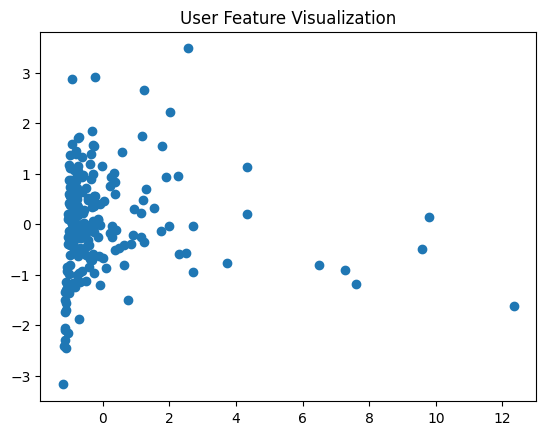

User 13 features: [-0.70213697 -0.43543518 -0.34354849 -0.36446666 -0.52625179  1.25254489]
User 9 features: [ 0.24196998 -0.13000284 -0.18778219 -0.16718967 -0.15898359 -0.35315056]
User 142 features: [-0.3945995  -0.3838953  -0.35680519 -0.36177477 -0.46504042 -0.56724329]
User 1 features: [3.73400826 3.56095519 2.61214458 2.95194041 1.4937233  0.69055148]
User 96 features: [-0.56820936 -0.42606429 -0.3893946  -0.36292844 -0.47524231  0.07503489]


In [19]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

user_feature_array = np.array([user_feature_dict[u] for u in user_feature_dict])
pca = PCA(n_components=2)
user_features_2d = pca.fit_transform(user_feature_array)

plt.scatter(user_features_2d[:, 0], user_features_2d[:, 1])
plt.title('User Feature Visualization')
plt.show()
for user_idx in user_indices[:5]:
    print(f"User {user_idx} features: {user_feature_dict[user_idx]}")

In [20]:
for business_idx in recommended_business_indices[:5]:
    print(f"Business {business_idx} features: {business_feature_dict[business_idx]}")

Business 27 features: [0. 0. 0. ... 0. 0. 0.]
Business 98 features: [0. 0. 0. ... 0. 0. 0.]
Business 179 features: [0. 0. 0. ... 0. 0. 0.]
Business 44 features: [0. 0. 0. ... 0. 0. 0.]
Business 38 features: [0. 0. 0. ... 0. 0. 0.]


In [17]:
user_indices = data['user_index'].unique()[:5]
k = 10  
recommendations = recall_top_k(model, user_indices, k)
for user_idx in user_indices:
    recommended_business_indices = recommendations[user_idx]
    recommended_business_ids = business_encoder.inverse_transform(recommended_business_indices)
    print(f"User {user_idx} 的 Top-{k} 推荐商家ID:")
    print(recommended_business_ids)
    print()

User 13 的 Top-10 推荐商家ID:
['C43IEVBroD_3YiumPPLLdQ' 'I6L0Zxi5Ww0zEWSAVgngeQ'
 'bdth7r1brx9yRU7sYwF9jQ' 'zJErbOQMKX-MwHs_ulV7DA'
 '8uF-bhJFgT4Tn6DTb27viA' 'mLNSOU8Ki0Fm09xd6ZKkcA'
 'Gv-DejGMGZOLCjju3UVQRA' 'pNu5bd9aL3jcJClfdQ86MQ'
 'CA5BOxKRDPGJgdUQ8OUOpw' 'jBCgQ6nZDsMCWU7eaSxOpw']

User 9 的 Top-10 推荐商家ID:
['bdth7r1brx9yRU7sYwF9jQ' 'zJErbOQMKX-MwHs_ulV7DA'
 'I6L0Zxi5Ww0zEWSAVgngeQ' '0Ga7YzSAIVZ8jrWwGE9m6Q'
 'RUCsFlBuA80Wc9PmYzmayQ' 'C43IEVBroD_3YiumPPLLdQ'
 'KCm9f7cROQ-f0iyYxFxQog' 'Gv-DejGMGZOLCjju3UVQRA'
 '8uF-bhJFgT4Tn6DTb27viA' 'pNu5bd9aL3jcJClfdQ86MQ']

User 142 的 Top-10 推荐商家ID:
['bdth7r1brx9yRU7sYwF9jQ' 'zJErbOQMKX-MwHs_ulV7DA'
 'C43IEVBroD_3YiumPPLLdQ' 'I6L0Zxi5Ww0zEWSAVgngeQ'
 '0Ga7YzSAIVZ8jrWwGE9m6Q' 'Gv-DejGMGZOLCjju3UVQRA'
 'pNu5bd9aL3jcJClfdQ86MQ' 'KCm9f7cROQ-f0iyYxFxQog'
 'RUCsFlBuA80Wc9PmYzmayQ' '8uF-bhJFgT4Tn6DTb27viA']

User 1 的 Top-10 推荐商家ID:
['C43IEVBroD_3YiumPPLLdQ' '0Ga7YzSAIVZ8jrWwGE9m6Q'
 'Gv-DejGMGZOLCjju3UVQRA' 'actDmpJyaQPnkds6knMdKA'
 'zJErbOQMKX-MwHs_ulV7DA' 'p

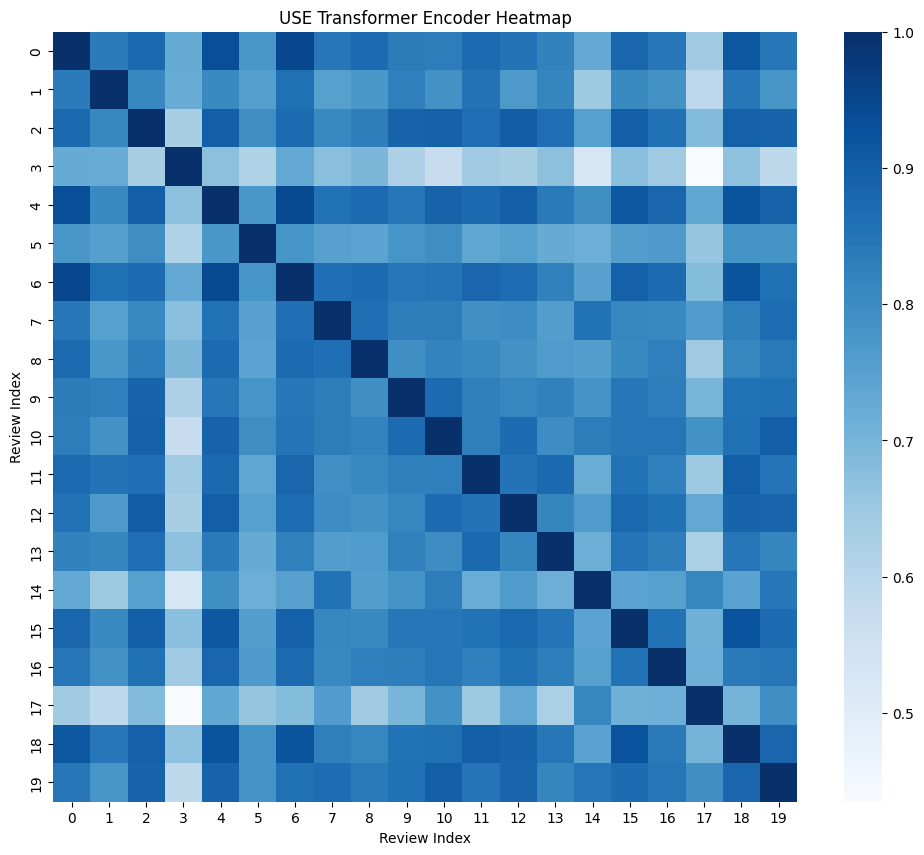

In [12]:
sample_size = 20
sample_data = data.sample(n=sample_size, random_state=42).reset_index(drop=True)
sample_embeddings = np.stack(sample_data['text_embedding'].values)
similarity_matrix = cosine_similarity(sample_embeddings)
plt.figure(figsize=(12, 10))
sns.heatmap(similarity_matrix, annot=False, cmap='Blues')
plt.title('USE Transformer Encoder Heatmap')
plt.xlabel('Review Index')
plt.ylabel('Review Index')
plt.show()


In [13]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
photo_df = pd.read_json('photos.json', lines=True,nrows=5000)
labels_to_use = ['food', 'drink', 'menu', 'inside', 'outside']
photo_df = photo_df[photo_df['label'].isin(labels_to_use)]
label_encoder = LabelEncoder()
photo_df['label_encoded'] = label_encoder.fit_transform(photo_df['label'])
train_photos, test_photos = train_test_split(photo_df, test_size=0.2, random_state=42, stratify=photo_df['label'])
def get_image_embedding(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        inputs = clip_processor(images=image, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = clip_model.get_image_features(**inputs)
        embedding = outputs.cpu().numpy()[0]
        return embedding
    except Exception:
        return np.zeros(512)
train_embeddings = []
for photo_id in train_photos['photo_id']:
    image_path = os.path.join('photos', f'{photo_id}.jpg')
    embedding = get_image_embedding(image_path)
    train_embeddings.append(embedding)
train_embeddings = np.array(train_embeddings)
test_embeddings = []
for photo_id in test_photos['photo_id']:
    image_path = os.path.join('photos', f'{photo_id}.jpg')
    embedding = get_image_embedding(image_path)
    test_embeddings.append(embedding)
test_embeddings = np.array(test_embeddings)
clf = LogisticRegression(max_iter=1000)
clf.fit(train_embeddings, train_photos['label_encoded'])
preds = clf.predict(test_embeddings)
true_labels = test_photos['label_encoded']
cm = confusion_matrix(true_labels, preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap='Blues', ax=ax, values_format='.2f')
plt.title('5-way Precision Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


KeyboardInterrupt: 

In [ ]:
unique_labels = photo_df['label'].unique()
print(unique_labels)
home_service_categories = ['inside', 'outside']
photo_df_home = photo_df[photo_df['label'].isin(home_service_categories)]

label_encoder_home = LabelEncoder()
photo_df_home['label_encoded'] = label_encoder_home.fit_transform(photo_df_home['label'])

train_photos_home, test_photos_home = train_test_split(photo_df_home, test_size=0.2, random_state=42, stratify=photo_df_home['label'])

train_embeddings_home = []
for photo_id in train_photos_home['photo_id']:
    image_path = os.path.join('photos', f'{photo_id}.jpg')
    embedding = get_image_embedding(image_path)
    train_embeddings_home.append(embedding)
train_embeddings_home = np.array(train_embeddings_home)

test_embeddings_home = []
for photo_id in test_photos_home['photo_id']:
    image_path = os.path.join('photos', f'{photo_id}.jpg')
    embedding = get_image_embedding(image_path)
    test_embeddings_home.append(embedding)
test_embeddings_home = np.array(test_embeddings_home)

clf_home = LogisticRegression(max_iter=1000)
clf_home.fit(train_embeddings_home, train_photos_home['label_encoded'])

preds_home = clf_home.predict(test_embeddings_home)
true_labels_home = test_photos_home['label_encoded']

cm_home = confusion_matrix(true_labels_home, preds_home, normalize='true')
disp_home = ConfusionMatrixDisplay(confusion_matrix=cm_home, display_labels=label_encoder_home.classes_)
fig, ax = plt.subplots(figsize=(8, 8))
disp_home.plot(cmap='Blues', ax=ax, values_format='.2f')
plt.title('Home Services Contractors Precision Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
from tqdm import tqdm
tqdm.pandas()

def get_text_embedding(text):
    if not isinstance(text, str) or text.strip() == '':
        return np.zeros(768)
    try:
        inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = bert_model(**inputs)
        embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()[0]
        return embedding
    except Exception as e:
        print(f"Error processing text: {text}")
        print(e)
        return np.zeros(768)

data = data.dropna(subset=['text'])
data['text_embedding'] = data['text'].progress_apply(get_text_embedding)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

sample_data = data.head(100)
embeddings = np.stack(sample_data['text_embedding'].values)

similarity_matrix = cosine_similarity(embeddings)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap='viridis')
plt.title('Yelp 评论相似性热力图')
plt.xlabel('评论索引')
plt.ylabel('评论索引')
plt.show()